Just testing the odebase with simple example


In [56]:
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import numpy as np

import torch
from torchinfo import summary

from pathlib import Path
from oceanwave_forecast import training
from oceanwave_forecast import models

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import statsmodels.api as sm
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PRELIMINARY ANALYSIS


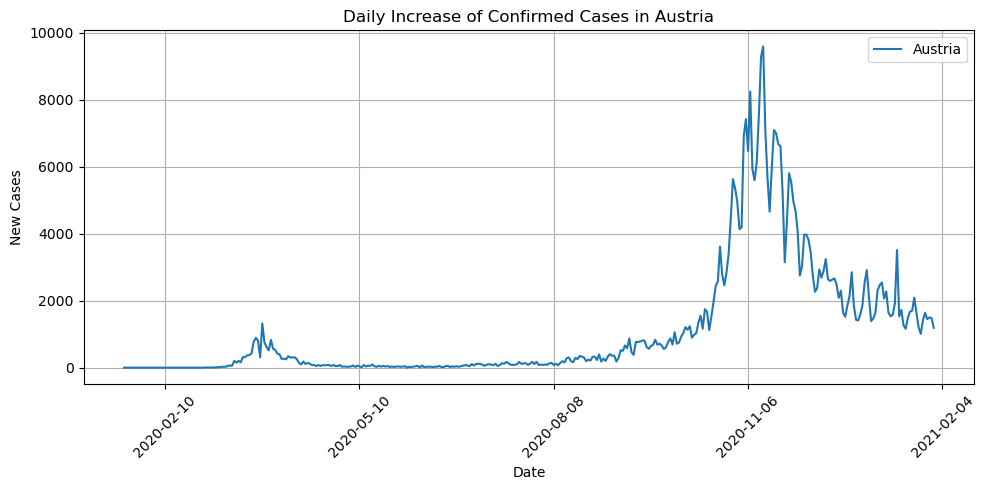

In [15]:
csv_path = "D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\raw\\COVID_19_until_2021_02_01.csv"

# 2) Load DataFrame, parse the Date column
df = pd.read_csv(csv_path, parse_dates=["Date"])

# 3) Filter Austria and compute daily increases
aus_df = df[df["Country"] == "Austria"].sort_values("Date")
aus_confirmed_diff = (
    aus_df["Confirmed"]
    .diff()
    .fillna(0)
    .values
)

# 4) Grab the corresponding dates
date_list = aus_df["Date"].values

# 5) Plot
plt.figure(figsize=(10, 5))
plt.plot(date_list, aus_confirmed_diff, label="Austria", linewidth=1.5)

plt.title("Daily Increase of Confirmed Cases in Austria")
plt.xlabel("Date")
plt.ylabel("New Cases")

# 6) Format ticks every 90 days
date_fmt = "%Y-%m-%d"
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=90))
plt.xticks(rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

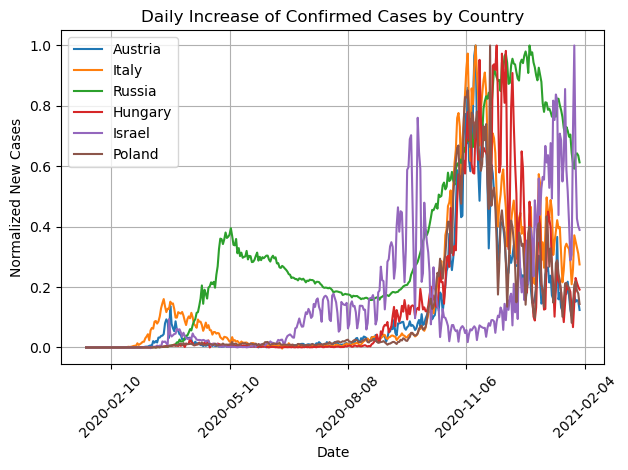

In [ ]:
countries = ["Austria", "Italy", "Russia", "Hungary", "Israel", "Poland"]
countries_count = len(countries)

# 4) Date formatter/locator
date_fmt = "%Y-%m-%d"
locator = mdates.DayLocator(interval=90)
formatter = mdates.DateFormatter(date_fmt)

for c in countries:
    # extract & sort by date
    c_df = df[df["Country"] == c].sort_values("Date")
    dates = c_df["Date"]
    # compute daily diffs and normalize
    diffs = c_df["Confirmed"].diff().fillna(0).values
    if diffs.max() > 0:
        diffs = diffs / diffs.max()
    # plot on the same axes
    plt.plot(dates, diffs, label=c)

# 7) Finalize plot
plt.title("Daily Increase of Confirmed Cases by Country")
plt.xlabel("Date")
plt.ylabel("Normalized New Cases")
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Detrending

### Using sktime

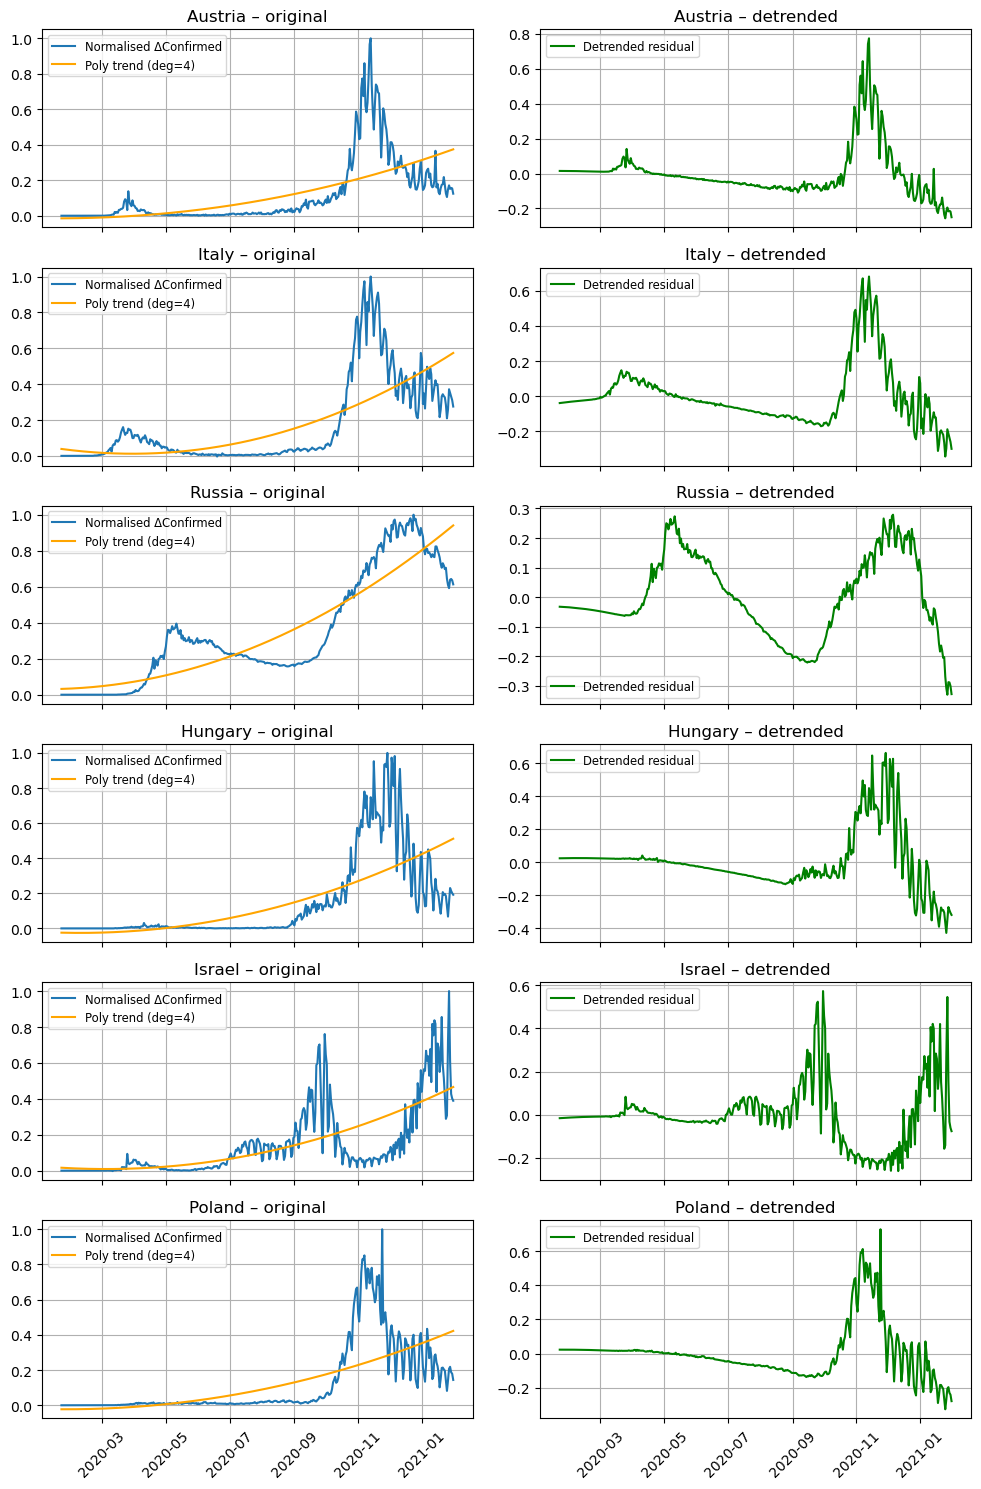

In [25]:
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
poly_deg = 4
fig, axes = plt.subplots(
    countries_count, 2, figsize=(10, 2.5 * countries_count), sharex="col", squeeze=False
)

for i, country in enumerate(countries):
    # ---------- build (normalised) daily-increase series ----------
    sub_df   = df[df["Country"] == country].sort_values("Date")
    diffs    = sub_df["Confirmed"].diff().fillna(0)
    ts       = diffs / diffs.max() if diffs.max() > 0 else diffs         # normalise
    ts.index = sub_df["Date"]                                            # ensure Date index

    # ---------- detrend with Detrender(PolynomialTrendForecaster) ----------
    detr = Detrender(
        forecaster=PolynomialTrendForecaster(degree=poly_deg), model="additive"
    )
    trend_removed = detr.fit_transform(ts)         # residual series
    trend_values  = ts - trend_removed             # the fitted trend itself

    # ---------- left subplot: original + trend ----------
    ax_left = axes[i, 0]
    ax_left.plot(ts, label="Normalised ΔConfirmed")
    ax_left.plot(trend_values, color="orange", label=f"Poly trend (deg={poly_deg})")
    ax_left.set_title(f"{country} – original")
    ax_left.grid(True)
    ax_left.legend(fontsize="small")

    # ---------- right subplot: detrended residual ----------
    ax_right = axes[i, 1]
    ax_right.plot(trend_removed, color="green", label="Detrended residual")
    ax_right.set_title(f"{country} – detrended")
    ax_right.grid(True)
    ax_right.legend(fontsize="small")

    # rotate x-tick labels for both panels
    for ax in (ax_left, ax_right):
        ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Statsmodel Time series FIlters:

 - Note the here we are not detrending, instead we are getting the smooth polynomial filter as feature for prediction

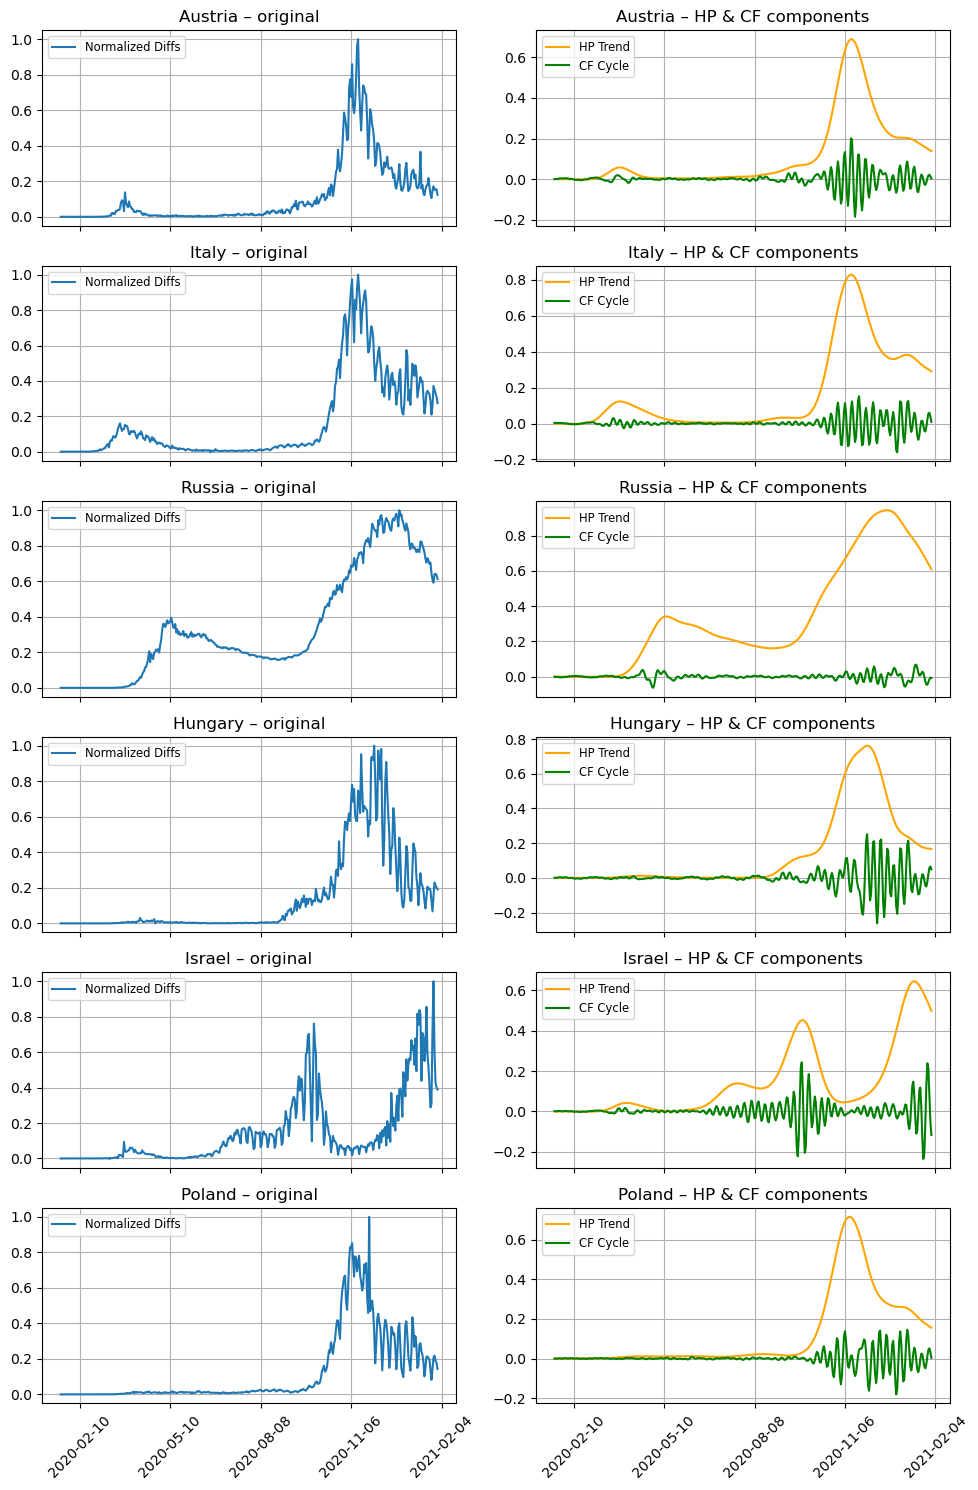

In [29]:
fig, axes = plt.subplots(countries_count, 2, figsize=(10, 2.5 * countries_count), sharex="col", squeeze=False)

# common date formatting
date_fmt = "%Y-%m-%d"
locator = mdates.DayLocator(interval=90)
formatter = mdates.DateFormatter(date_fmt)

for i, country in enumerate(countries):
    # 1) extract & normalize daily diffs
    sub = df[df["Country"] == country].sort_values("Date")
    dates = sub["Date"]
    diffs = sub["Confirmed"].diff().fillna(0).values
    ts = diffs / diffs.max() if diffs.max() > 0 else diffs

    # 2) compute HP trend & CF cycle
    hp_cycle, hp_trend = sm.tsa.filters.hpfilter(ts)
    cf_cycle, _        = sm.tsa.filters.cffilter(ts)

    # --- left panel: original series ---
    ax0 = axes[i, 0]
    ax0.plot(dates, ts, label="Normalized Diffs")
    ax0.set_title(f"{country} – original")
    ax0.grid(True)
    ax0.legend(fontsize="small")
    ax0.xaxis.set_major_locator(locator)
    ax0.xaxis.set_major_formatter(formatter)
    ax0.tick_params(axis="x", rotation=45)

    # --- right panel: HP trend & CF cycle ---
    ax1 = axes[i, 1]
    ax1.plot(dates, hp_trend, color="orange", label="HP Trend")
    ax1.plot(dates, cf_cycle, color="green", label="CF Cycle")
    ax1.set_title(f"{country} – HP & CF components")
    ax1.grid(True)
    ax1.legend(fontsize="small")
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# ANALYSIS AND MODELING

In [72]:

# ------------------------------ EXPERIMENT CONFIG ------------
CFG = {
    # data / windowing
    "countries": ["Italy", "Russia", "Hungary", "Austria", "Israel", "Poland"],
    "window":      120,
    "horizon":      60,
    "val_split":   0.2,      # 20 % validation

    # model
    "hidden_size": 64,
    "hidden_fc":   64,
    "teacher_ratio": 0.5,

    # optimiser
    "lr": 0.001,
    "epochs": 1000,
}

In [ ]:
EXPERIMENT_NAME = "COVID_simple_model" # NOTE mlflow always require the exp name to be unique
RUN_NUMBER      = 4

TAGS = {                       # add whatever you need
    "project": "covid",
    # "owner"  : "akash",
}

# ── helper ───────────────────────────────────────────────────────────
def get_or_create_experiment(name: str, tags: dict) -> mlflow.entities.Experiment:
    """
    Return an experiment whose *name* == `name` AND whose tag set ⊇ `tags`.
    If none exists (or tags differ), create a NEW experiment with a unique
    name derived from `name`.
    """
    exp_list = mlflow.search_experiments(
        filter_string=f"name LIKE '{name}%'",
        view_type=ViewType.ALL,
    )

    # try exact match on name AND tags
    for exp in exp_list:
        if exp.name == name:
            return exp

    # otherwise, invent a unique name
    suffix = 1
    candidate_name = name
    existing_names = {e.name for e in exp_list}
    while candidate_name in existing_names:
        suffix += 1
        candidate_name = f"{name}_{suffix}"

    exp_id = mlflow.create_experiment(candidate_name, tags=tags)
    return mlflow.get_experiment(exp_id)

exp = get_or_create_experiment(EXPERIMENT_NAME, TAGS)

# ── does an identical (finished) run already exist?  -----------------
existing_runs = mlflow.search_runs(
    experiment_ids=[exp.experiment_id],
    filter_string=f"params.run_number = '{RUN_NUMBER}'",
    run_view_type=ViewType.ALL,
    output_format="list",
    max_results=1,
)

if existing_runs and existing_runs[0].info.status == "FINISHED":
    run = existing_runs[0]
    print(f"🟢  Finished run already logged (id={run.info.run_id}) – skipping.")
else:
    resume_id = existing_runs[0].info.run_id if existing_runs else None
    with mlflow.start_run(
        experiment_id=exp.experiment_id,
        run_name=f"run_{RUN_NUMBER:03d}",
        run_id=resume_id,
    ) as run:

        # log params only once
        if not run.data.params:
            mlflow.log_param("run_number", RUN_NUMBER)
            mlflow.log_params({k: v for k, v in CFG.items() if k != "countries"})
            mlflow.log_param("countries", ",".join(CFG["countries"]))

        best_val, best_model = training.train_once(CFG)
        mlflow.log_metric("best_val_mse", best_val)

        ckpt = Path("best_model.pth")
        torch.save(best_model.state_dict(), ckpt)
        mlflow.log_artifact(str(ckpt))
        mlflow.pytorch.log_model(best_model, artifact_path="model")

    print(f"✅  Run complete (id={run.info.run_id})")

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:476: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  return pd.read_csv(


Loaded DataFrame → rows = 103400, unique countries = 192
[Italy] raw diffs → ts.shape = (375,)
[Italy] feature matrix → feats.shape = (375, 3)
[Italy] sliding_window → X_c.shape = (196, 120, 3); Y_c.shape = (196, 60, 3)
[Russia] raw diffs → ts.shape = (375,)
[Russia] feature matrix → feats.shape = (375, 3)
[Russia] sliding_window → X_c.shape = (196, 120, 3); Y_c.shape = (196, 60, 3)
[Hungary] raw diffs → ts.shape = (375,)
[Hungary] feature matrix → feats.shape = (375, 3)
[Hungary] sliding_window → X_c.shape = (196, 120, 3); Y_c.shape = (196, 60, 3)
[Austria] raw diffs → ts.shape = (375,)
[Austria] feature matrix → feats.shape = (375, 3)
[Austria] sliding_window → X_c.shape = (196, 120, 3); Y_c.shape = (196, 60, 3)
[Israel] raw diffs → ts.shape = (375,)
[Israel] feature matrix → feats.shape = (375, 3)
[Israel] sliding_window → X_c.shape = (196, 120, 3); Y_c.shape = (196, 60, 3)
[Poland] raw diffs → ts.shape = (375,)
[Poland] feature matrix → feats.shape = (375, 3)
[Poland] sliding_windo

2025/05/29 23:32:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅  Run complete (id=5e40ec1e95c944a6a4c75f0d050be05c)


## Checking the Run

In [77]:
# PRINTS ALL THE AVAILABLE EXPS BY TAGS AND ITS RUNS:

TAG_KEY, TAG_VALUE = "project", "covid"     # single tag
# ── find experiments whose *experiment-level* tag matches ──────────
experiments = mlflow.search_experiments(
    view_type=ViewType.ALL,
    filter_string=f"tags.{TAG_KEY} = '{TAG_VALUE}'",
)
print(experiments)

def _print_tree(run, children_map, level=0):
    pad   = "  " * level
    name  = run.data.tags.get("mlflow.runName", "")
    print(f"{pad}• {name or run.info.run_id} "
          f"(run_id={run.info.run_id}, status={run.info.status})")
    for child in children_map.get(run.info.run_id, []):
        _print_tree(child, children_map, level + 1)

for exp in experiments:
    print(f"\n=== Experiment: {exp.name}  (id={exp.experiment_id}) ===")

    # fetch *all* runs for this experiment as Run objects
    runs = mlflow.search_runs(
        experiment_ids=[exp.experiment_id],
        run_view_type=ViewType.ALL,
        output_format="list",
        max_results=100_000,
    )

    # build parent → children map
    children_map, roots = {}, []
    for r in runs:
        parent = r.data.tags.get("mlflow.parentRunId")
        (children_map.setdefault(parent, []).append(r)
         if parent else roots.append(r))

    # pretty-print
    for r in roots:
        _print_tree(r, children_map)


[<Experiment: artifact_location='file:///d:/CML/Term%208/ML%20projects/forecasting_workspace/oceanwave_forecast/notebooks/mlruns/240533425331854824', creation_time=1748577243335, experiment_id='240533425331854824', last_update_time=1748577243335, lifecycle_stage='active', name='COVID_simple_model', tags={'project': 'covid'}>]

=== Experiment: COVID_simple_model  (id=240533425331854824) ===
• run_004 (run_id=5e40ec1e95c944a6a4c75f0d050be05c, status=FINISHED)
• run_003 (run_id=7413b01ba84e46a09ba1eeead2648e60, status=FINISHED)
• run_002 (run_id=8a3e10e93b94485db13193115cca3a47, status=FINISHED)
• run_001 (run_id=9d2e15d865d8415fa436fee8497138bd, status=FINISHED)


Selected run_id = 5e40ec1e95c944a6a4c75f0d050be05c

=== Parameters ===
Series([], dtype: object)

=== Tags ===
mlflow.runName                                                  run_004
mlflow.source.name    c:\Users\akashv22\AppData\Local\anaconda3\envs...
mlflow.source.type                                                LOCAL
mlflow.user                                                    akashv22
dtype: object

=== Metrics (last recorded value) ===
Series([], dtype: object)

=== Artifacts ===
best_model.pth
model


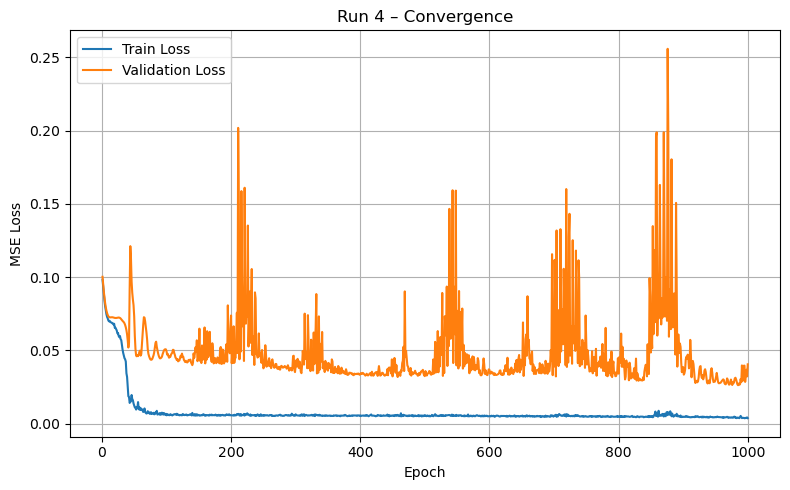

In [78]:
# GETS EXP BY THE NAME AND PARTICULAR RUN
client     = MlflowClient()
exp        = client.get_experiment_by_name(EXPERIMENT_NAME)

# Pull all runs for the experiment; pick the one with matching run_number
runs = client.search_runs(exp.experiment_id,
                          filter_string=f"params.run_number = '{RUN_NUMBER}'",
                          order_by=["attribute.start_time DESC"],
                          max_results=1)

assert len(runs) == 1, f"Error: expected exactly one run, but got {len(run)}"
    
run_id = run.info.run_id
print(f"Selected run_id = {run_id}")

# ------------------------------------------------------------------
# 2)  Inspect what was logged
# ------------------------------------------------------------------
print("\n=== Parameters ===")
print(pd.Series(run.data.params))

print("\n=== Tags ===")
print(pd.Series(run.data.tags))

print("\n=== Metrics (last recorded value) ===")
print(pd.Series(run.data.metrics))

print("\n=== Artifacts ===")
for f in client.list_artifacts(run_id):
    print(f.path)

# ------------------------------------------------------------------
# 3)  Retrieve the full train/val-loss histories and plot convergence
# ------------------------------------------------------------------
train_hist = client.get_metric_history(run_id, "train_loss")
val_hist   = client.get_metric_history(run_id, "val_loss")

# Sort by epoch (metric.step)
train_hist = sorted(train_hist, key=lambda m: m.step)
val_hist   = sorted(val_hist,   key=lambda m: m.step)

epochs     = [m.step  for m in train_hist]
train_loss = [m.value for m in train_hist]
val_loss   = [m.value for m in val_hist]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss,   label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Run {RUN_NUMBER} – Convergence")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()



# Model Evaluation

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:476: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  return pd.read_csv(


Loaded DataFrame → rows = 103400, unique countries = 192
[Italy] raw diffs → ts.shape = (375,)
[Italy] feature matrix → feats.shape = (375, 3)
[Italy] sliding_window → X_c.shape = (196, 120, 3); Y_c.shape = (196, 60, 3)
[Russia] raw diffs → ts.shape = (375,)
[Russia] feature matrix → feats.shape = (375, 3)
[Russia] sliding_window → X_c.shape = (196, 120, 3); Y_c.shape = (196, 60, 3)
[Hungary] raw diffs → ts.shape = (375,)
[Hungary] feature matrix → feats.shape = (375, 3)
[Hungary] sliding_window → X_c.shape = (196, 120, 3); Y_c.shape = (196, 60, 3)
[Austria] raw diffs → ts.shape = (375,)
[Austria] feature matrix → feats.shape = (375, 3)
[Austria] sliding_window → X_c.shape = (196, 120, 3); Y_c.shape = (196, 60, 3)
[Israel] raw diffs → ts.shape = (375,)
[Israel] feature matrix → feats.shape = (375, 3)
[Israel] sliding_window → X_c.shape = (196, 120, 3); Y_c.shape = (196, 60, 3)
[Poland] raw diffs → ts.shape = (375,)
[Poland] feature matrix → feats.shape = (375, 3)
[Poland] sliding_windo

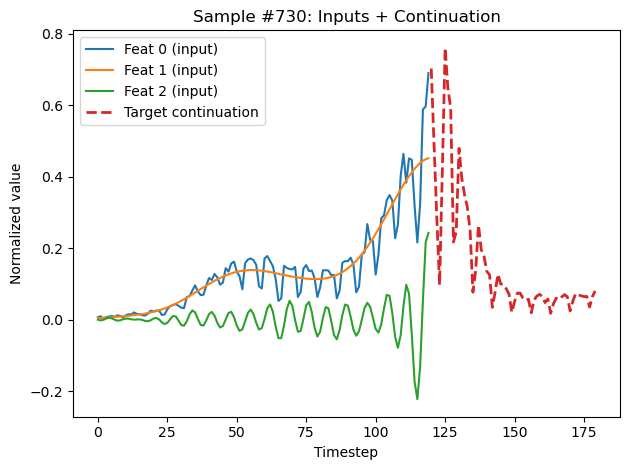

In [71]:
(x_tr, y_tr), (x_val, y_val) = training.make_datasets(CFG)
training.plot_random_sample(x_tr, y_tr)


In [91]:
csv_path = "D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\raw\\COVID_19_until_2021_02_01.csv"
df = pd.read_csv(csv_path, parse_dates=["Date"])
country = 'Russia'

# Filter Austria and compute daily increases
sub = df[df["Country"] == country].sort_values("Date").reset_index(drop=True)
dates = sub["Date"]
diffs = sub["Confirmed"].diff().fillna(0).values
max_value = diffs.max()
ts = diffs / max_value if diffs.max() > 0 else diffs

# Compute HP trend & CF cycle for the entire series
hp_cycle, hp_trend = sm.tsa.filters.hpfilter(ts)
cf_cycle, _ = sm.tsa.filters.cffilter(ts)

# Prepare feature matrix
X_full = []
for i in range(len(ts)):
    X_full.append([ts[i], hp_trend[i], cf_cycle[i]])


In [92]:
# =============================================================================
# 2) Split data for evaluation
# =============================================================================

horizon = 60
lookback_window = 200  # Adjust based on your model's training sequence length

# Ensure we have enough data for both input and ground truth
total_needed = lookback_window + horizon
if len(ts) < total_needed:
    raise ValueError(f"Not enough data. Need {total_needed}, got {len(ts)}")

# Split point: use last 'horizon' days as ground truth, previous days for input
split_idx = len(ts) - horizon

# Input data: everything up to split point, take last 'lookback_window' for model input
X_input = X_full[split_idx - lookback_window:split_idx]
X_input = torch.tensor([X_input]).float().transpose(0, 1)  # (seq_len, batch=1, features=3)

# Ground truth: actual values for the prediction horizon
y_truth = ts[split_idx:split_idx + horizon]  # Original normalized values
dates_truth = dates.iloc[split_idx:split_idx + horizon]

# Input sequence dates (for plotting context)
dates_input = dates.iloc[split_idx - lookback_window:split_idx]
ts_input = ts[split_idx - lookback_window:split_idx]

print(f"Input sequence: {len(X_input)} days")
print(f"Prediction horizon: {horizon} days")
print(f"Input date range: {dates_input.iloc[0]} to {dates_input.iloc[-1]}")
print(f"Prediction date range: {dates_truth.iloc[0]} to {dates_truth.iloc[-1]}")

Input sequence: 200 days
Prediction horizon: 60 days
Input date range: 2020-05-17 00:00:00 to 2020-12-02 00:00:00
Prediction date range: 2020-12-03 00:00:00 to 2021-01-31 00:00:00


In [93]:
# Load the model
model_uri = f"runs:/{run_id}/model"  # Make sure run_id is defined
model = mlflow.pytorch.load_model(model_uri)
model.eval()
device = next(model.parameters()).device

# Send data to device
X_input = X_input.to(device)

# Make prediction
with torch.inference_mode():
    y_pred = model.predict(X_input, horizon=horizon)

# Convert predictions back to CPU and squeeze
y_pred = y_pred.cpu().squeeze().numpy()  # (horizon,)

print(f"Prediction shape: {y_pred.shape}")
print(f"Ground truth shape: {y_truth.shape}")
# Mean Absolute Error
mae = np.mean(np.abs(y_pred - y_truth))

# Root Mean Square Error
rmse = np.sqrt(np.mean((y_pred - y_truth) ** 2))

# Mean Absolute Percentage Error (handle division by zero)
mape = np.mean(np.abs((y_truth - y_pred) / np.maximum(np.abs(y_truth), 1e-8))) * 100

print(f"\nEvaluation Metrics:")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.2f}%")



Prediction shape: (60,)
Ground truth shape: (60,)

Evaluation Metrics:
MAE: 0.046961
RMSE: 0.055865
MAPE: 6.03%


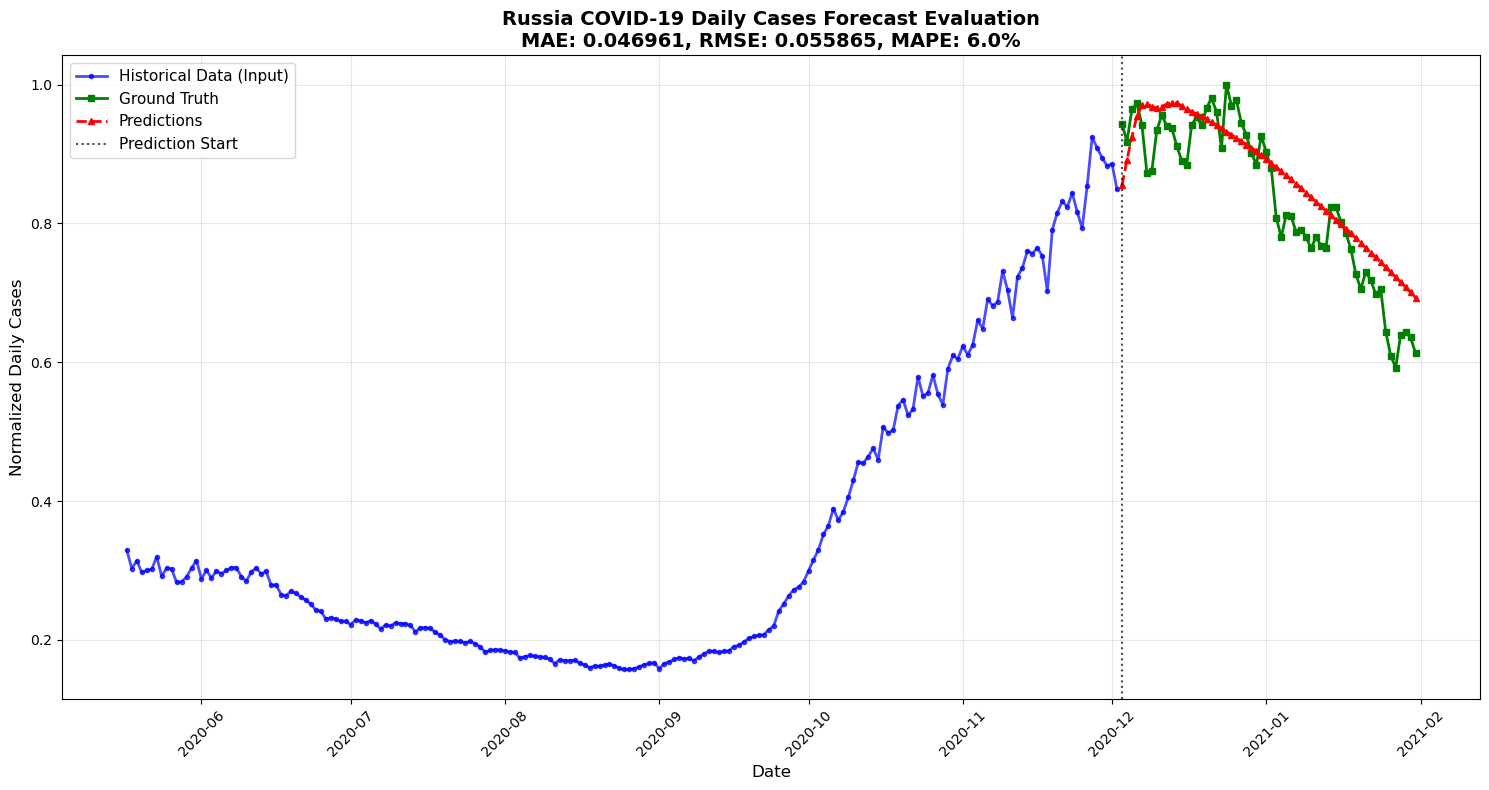

In [94]:
plt.figure(figsize=(15, 8))

# Plot input sequence for context
plt.plot(dates_input, ts_input, 'b-', alpha=0.7, linewidth=2, 
         label=f'Historical Data (Input)', marker='o', markersize=3)

# Plot ground truth
plt.plot(dates_truth, y_truth, 'g-', linewidth=2, 
         label='Ground Truth', marker='s', markersize=4)

# Plot predictions
plt.plot(dates_truth, y_pred, 'r--', linewidth=2, 
         label='Predictions', marker='^', markersize=4)

# Add vertical line at prediction start
plt.axvline(x=dates_truth.iloc[0], color='black', linestyle=':', alpha=0.7,
            label='Prediction Start')

# Formatting
plt.title(f'{country} COVID-19 Daily Cases Forecast Evaluation\n'
          f'MAE: {mae:.6f}, RMSE: {rmse:.6f}, MAPE: {mape:.1f}%', 
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Daily Cases', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

